In [0]:
# import dependencies
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import itertools

In [0]:
# four actions' index
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

In [0]:
# environment class
class WindyGridworld():

  def __init__(self):
    self.shape = (7, 10)
    self.nA = 4 #number of probable actions
    nS = 70 #number of states
    self.state = np.ravel_multi_index((3,0), self.shape)

    # reward for each move is -1 and if reach target reward is 10
    self.reward = -np.ones((nS,))
    self.reward[np.ravel_multi_index((3,7), self.shape)] = 10
    
    # wind strength
    self.winds = np.zeros(self.shape)
    self.winds[:,[3,4,5,8]] = 1
    self.winds[:,[6,7]] = 2
  
    # four actions' coordinates
    self.actions = [[1,0],[0,1],[-1,0],[0,-1]]
    
  # function used to limit the move inside the grid world
  def _limit_coordinates(self, coord):
    coord[0] = min(coord[0], self.shape[0] - 1)
    coord[0] = max(coord[0], 0)
    coord[1] = min(coord[1], self.shape[1] - 1)
    coord[1] = max(coord[1], 0)
    
    return coord

  # function used to take one step
  def step(self,action):
    current = np.unravel_index(self.state, self.shape)
    # new position are determined by both action and wind
    new_position = np.array(current) + np.array(self.actions[action]) + np.array([1, 0]) * self.winds[tuple(current)]
    new_position = self._limit_coordinates(new_position).astype(int)
    new_state = np.ravel_multi_index(tuple(new_position), self.shape)
    self.state = new_state
    # if reached (3,7) then done
    is_done = tuple(new_position) == (3, 7)

    return new_state, self.reward[new_state], is_done

  # function used to reset state
  def reset(self):
    self.state = np.ravel_multi_index((3,0), self.shape)


In [0]:
env=WindyGridworld()

In [0]:
# greedy policy returns probablity of taking each action
def epsilon_greedy_policy(Q, state, nA, epsilon):
    probs = np.ones(nA) * epsilon / nA
    best_action = np.argmax(Q[state])
    probs[best_action] += 1.0 - epsilon

    return probs

In [0]:
def sarsa(episodes, learning_rate, discount, epsilon):
    
    # Links state to action values
    Q = defaultdict(lambda: np.zeros(env.nA))

    # Points to plot
    # number of episodes
    x = np.arange(episodes)
    # Number of steps
    y = np.zeros(episodes)
    
    for episode in range(episodes):
      state = env.reset()
      probs = epsilon_greedy_policy(Q, state, env.nA, epsilon)
      action = np.random.choice(np.arange(len(probs)), p=probs)

      for step in itertools.count():  
        # Select and take action
        next_state, reward, done = env.step(action)
        next_probs = epsilon_greedy_policy(Q, next_state, env.nA, epsilon)
        next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
        # TD Update
        td_target = reward + discount * Q[next_state][next_action]
        td_error = td_target - Q[state][action]
        Q[state][action] += learning_rate * td_error
    
        if done:
          y[episode] = step
          break

        action = next_action
        state = next_state    
  
    return x, y      

In [0]:
def Q_learning(episodes, learning_rate, discount, epsilon):
  
    # Links state to action values
    Q = defaultdict(lambda: np.zeros(env.nA))

    # Points to plot
    # number of episodes
    x = np.arange(episodes)
    # Number of steps
    y = np.zeros(episodes)

    for episode in range(episodes):
      state = env.reset()

      for step in itertools.count():
        
        # Select and take action
        probs = epsilon_greedy_policy(Q, state, env.nA, epsilon)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        next_state, reward, done = env.step(action)

        # TD Update
        td_target = reward + discount * np.amax(Q[next_state])
        td_error = td_target - Q[state][action]
        Q[state][action] += learning_rate * td_error

        if done:
          y[episode] = step
          break

        state = next_state

    return x, y

    

In [0]:
def sarsa_lambda(episodes, learning_rate, discount, epsilon, _lambda):
    
    # Links state to action values
    Q = defaultdict(lambda: np.zeros(env.nA))
    # Eligibility trace
    e = defaultdict(lambda: np.zeros(env.nA))

    # Points to plot
    # number of episodes
    x = np.arange(episodes)
    # Number of steps
    y = np.zeros(episodes)
    
    for episode in range(episodes):
      state = env.reset()
        
      # Select action
      probs = epsilon_greedy_policy(Q, state, env.nA, epsilon)
      action = np.random.choice(len(probs), p=probs)

      for step in itertools.count():
        # Take action
        next_state, reward, done = env.step(action)

        # Select next action
        probs = epsilon_greedy_policy(Q, next_state, env.nA, epsilon)
        next_action = np.random.choice(len(probs), p=probs)

        # Get update value
        td_target = reward + discount * Q[next_state][next_action]
        td_error = td_target - Q[state][action]
        
        e[state][action] += 1
        
        # Update all states
        for s in Q:
          for a in range(len(Q[s])):         
            # Update Q value based on eligibility trace
            Q[s][a] += learning_rate * td_error * e[s][a]       
            e[s][a] = discount * _lambda * e[s][a]

        if done:
          y[episode] = step
          e.clear()
          break

        # Update action and state
        action = next_action
        state = next_state
  
    return x, y      

In [0]:
def Q_learning_lambda(episodes, learning_rate, discount, epsilon, _lambda):

    # Link state to action values
    Q = defaultdict(lambda: np.zeros(env.nA))
    # Eligibility trace
    e = defaultdict(lambda: np.zeros(env.nA))
    
    # Points to plot
    # number of episodes
    x = np.arange(episodes)
    # number of steps
    y = np.zeros(episodes)

    for episode in range(episodes):
      state = env.reset()

      # Select action
      probs = epsilon_greedy_policy(Q, state, env.nA, epsilon)
      action = np.random.choice(len(probs), p=probs)

      for step in itertools.count():
            
        # Take action
        next_state, reward, done = env.step(action)

        # Select next action
        probs = epsilon_greedy_policy(Q, next_state, env.nA, epsilon)
        next_action = np.random.choice(len(probs), p=probs)

        # Get update value
        best_next_action = np.argmax(Q[next_state])
        td_target = reward + discount * Q[next_state][best_next_action]
        td_error = td_target - Q[state][action]

        e[state][action] += 1

        # Update all states
        for s in Q:
          for a in range(len(Q[s])):      
            # Update Q value based on eligibility trace
            Q[s][a] += learning_rate * td_error * e[s][a]

            # Decay eligibility trace if best action is taken
            if next_action is best_next_action:
              e[s][a] = discount * _lambda * e[s][a]
            # Reset eligibility trace if random action taken
            else:
              e[s][a] = 0        

        if done:
          y[episode] = step
          e.clear()
          break

        # Update action and state
        action = next_action
        state = next_state

    return x, y

In [0]:
# parameters
episodes = 100
learning_rate = 0.3
discount = 0.9
epsilon = 0.05
_lambda = 0.9

In [0]:
x1, y1 = sarsa(episodes, learning_rate, discount, epsilon)
x2, y2 = Q_learning(episodes, learning_rate, discount, epsilon)
x3, y3 = sarsa_lambda(episodes, learning_rate, discount, epsilon, _lambda)
x4, y4 = Q_learning_lambda(episodes, learning_rate, discount, epsilon, _lambda)

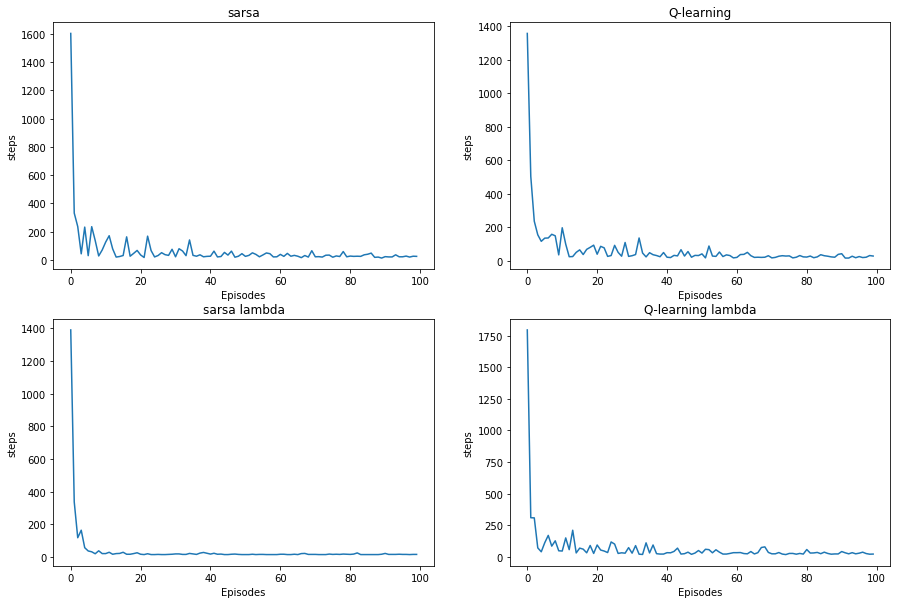

In [0]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0,0].plot(x1,y1)
ax[0,0].set(xlabel='Episodes', ylabel='steps',
       title='sarsa')
ax[0,1].plot(x2,y2)
ax[0,1].set(xlabel='Episodes', ylabel='steps',
       title='Q-learning')
ax[1,0].plot(x3,y3)
ax[1,0].set(xlabel='Episodes', ylabel='steps',
       title='sarsa lambda')
ax[1,1].plot(x4,y4)
ax[1,1].set(xlabel='Episodes', ylabel='steps',
       title='Q-learning lambda')


plt.show()

In [0]:
# eight actions' index
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
UPLEFT = 4
UPRIGHT = 5
DOWNLEFT = 6
DOWNRIGHT = 7

In [0]:
# windy grid world with king's move and stochastic wind
class WindyGridworldWithKingsMove():
  def __init__(self):
    self.shape = (7, 10)
    self.nA = 8 # number of probable actions
    nS=70
    self.state = np.ravel_multi_index((3,0), self.shape)
    self.reward = -np.ones((nS,))
    self.reward[np.ravel_multi_index((3,7), self.shape)] = 10
    
    # Wind strength
    self.winds = np.zeros(self.shape)
    self.winds[:,[3,4,5,8]] = 1
    self.winds[:,[6,7]] = 2
  
    self.actions = [[1,0],[0,1],[-1,0],[0,-1],[1,-1],[1,1],[-1,-1],[-1,1]]
    

  def _limit_coordinates(self, coord):
    coord[0] = min(coord[0], self.shape[0] - 1)
    coord[0] = max(coord[0], 0)
    coord[1] = min(coord[1], self.shape[1] - 1)
    coord[1] = max(coord[1], 0)
    return coord

  def step(self,action):
    current = np.unravel_index(self.state, self.shape)
    # stochastic winds
    if self.winds[tuple(current)]==0:
      kings_move_force=0
    else:
      kings_move_force=np.random.randint(self.winds[tuple(current)]+1)
    new_position = np.array(current) + np.array(self.actions[action]) + np.array([1, 0]) * kings_move_force
    new_position = self._limit_coordinates(new_position).astype(int)
    new_state = np.ravel_multi_index(tuple(new_position), self.shape)
    self.state = new_state
    is_done = tuple(new_position) == (3, 7)
    return new_state, self.reward[new_state], is_done
  
  def reset(self):
    self.state = np.ravel_multi_index((3,0), self.shape)

In [0]:
env = WindyGridworldWithKingsMove()

In [0]:
# parameters
episodes = 100
learning_rate = 0.5
discount = 0.9
epsilon = 0.05
_lambda = 0.9

In [0]:
x1, y1 = sarsa(episodes, learning_rate, discount, epsilon)
x2, y2 = Q_learning(episodes, learning_rate, discount, epsilon)
x3, y3 = sarsa_lambda(episodes, learning_rate, discount, epsilon, _lambda)
x4, y4 = Q_learning_lambda(episodes, learning_rate, discount, epsilon, _lambda)

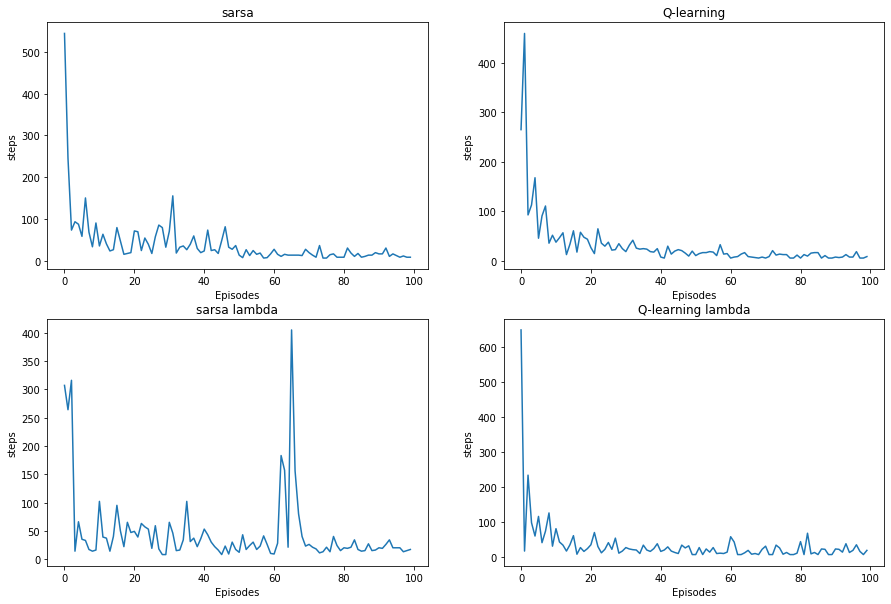

In [46]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0,0].plot(x1,y1)
ax[0,0].set(xlabel='Episodes', ylabel='steps',
       title='sarsa')
ax[0,1].plot(x2,y2)
ax[0,1].set(xlabel='Episodes', ylabel='steps',
       title='Q-learning')
ax[1,0].plot(x3,y3)
ax[1,0].set(xlabel='Episodes', ylabel='steps',
       title='sarsa lambda')
ax[1,1].plot(x4,y4)
ax[1,1].set(xlabel='Episodes', ylabel='steps',
       title='Q-learning lambda')


plt.show()